# Laboratorio 4: Gradient Descent Variants y Newton's Method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problema 1 - Gradient Descent Variants

En este primer problema del laboratorio, consideraremos el problema de ajustar una recta de regresión a un conjunto de datos. El modelo de regresión está dado por la ecuación $Ax=b$, en donde $A$ representa el conjunto de entradas de dimensión $n \times d$ y $b$ representa el conjunto de observaciones de dimensión $n \times 1$. El objetivo es determinar el vector de coeficientes $x$ de dimensión $d \times 1$ y que minimiza la suma de errores al cuadrado:

$$
\operatorname{mín}_{x \in \mathbb{R}^{d}} f(x) \triangleq \sum_{i=1}^{n} f_{i}(x)
$$

en donde, $f_{i}(x)=\left(x^{T} a_{i}-b_{i}\right)^{2}$ denota el cuadrado del error de la $i$-ésima observación $a_{i} \in \mathbb{R}^{d}$ y $b_{i} \in \mathbb{R}$. Se utilizarán los datos previamente explicados para estudiar cuatro formas diferentes de calcular el vector $x^*$, estas son: Solución cerrada, el algoritmo Gradient Descent (GD), el algoritmo de Stochastic Gradient Descent (SGD) y Mini Batch Gradient Descent (MBGD).

### Generación de Datos

In [2]:
# Columnas del dataset
d = 100

# Observaciones del dataset
n = 1000

# Matriz A (1000 x 100)
# Valores extraídos independientemente de una distribución Gaussiana de "d" dimensiones
A = np.random.normal(0, 1, size=(n,d))      

# Vector de coeficientes "verdadero" (100 x 1)
# Valores extraídos de una distribución Gaussiana de "d" dimensiones
X_true = np.random.normal(0, 1, size=(d,1))

# Vector de coeficientes "b"  (1000, 1)
# Se asigna a cada observación a_i la etiqueta "(x*)T a_i" más un componente de ruido
b = A.dot(X_true) + np.random.normal(0, 0.5, size=(n,1))

# Función objetivo
f = lambda x : np.sum((A @ x - b)**2, axis=0, keepdims=True).item()

# Valor de función objetivo "real" 
f(X_true)

238.66350575370936

### Parte 1 - Solución Cerrada

El problema puede resolverse de manera cerrada a través de la siguiente ecuación:

$$
x^{*}=\left(A^{T} A\right)^{-1} A^{T} b
$$

Utilizando la data generada con el código anterior, calcule el valor de $x^*$ así como el valor de la función objetivo $f$. ¿Por qué en la práctica no se utiliza este método? Justifique su respuesta.

In [3]:
# Dims: (100xN)(Nx100)(100xN)(Nx1) = (100x1)
X_exa = np.linalg.inv(A.T @ A) @ A.T @ b

# Valor de la función objetivo
print(f"Valor de Función Objetivo: {f(X_exa)}")

Valor de Función Objetivo: 216.39381333321762


- En la práctica no se tiende a utilizar este método, ya que la carga computacional asociada a obtener la inversa de una matriz crece exponencialmente a medida que las dimensiones de la misma incrementan. Si este problema se tratara de una regresión lineal con un millón de muestras, por ejemplo, la matriz $A$ se tornaría en una matriz de (1000000x100), por lo que al producto $A^T A$ le tomaría mucho tiempo ser invertido. Esto se puede probar empíricamente al invertir una matriz cuadrada aleatoria un total de 10 veces, cada vez utilizando dimensiones cada vez mayores. Si se mide el tiempo de ejecución para estas 10 instrucciones, se podrá observar que el tiempo de ejecución incrementa exponencialmente.

Inv Matriz 1x1: 0.002221700007794425
Inv Matriz 10x10: 0.0025628999865148216
Inv Matriz 100x100: 0.1664452999830246
Inv Matriz 1000x1000: 3.0119156999862753
Inv Matriz 10000x10000: 373.6012941999943


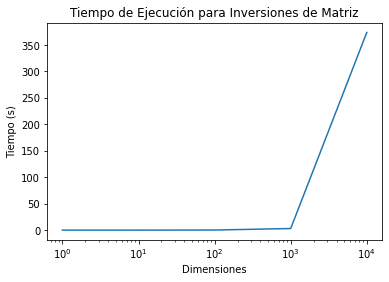

In [118]:
import timeit

# Dimensiones a probar para la matriz cuadrada "A"
dims = [1, 10, 100, 1000, 10000]

# Lista para los tiempos
codeTimes = []

# Para cada valor de dimensionalidad 
for dim in dims:

    # Código que solo se ejecuta 1 vez
    codeSetup = f"import numpy as np; A = np.random.normal(0, 1, size=({str(dim)}, {str(dim)}))" 

    # Código al que se le va a medir su rendimiento
    codeTest = "np.linalg.inv(A)"   

    # Se cronometra la ejecución del código y se imprimen los resultados
    # Cada inversión de la matriz se ejecuta 10 veces
    codeTime = timeit.timeit(setup=codeSetup, stmt=codeTest, number=10)
    print(f"Inv Matriz {dim}x{dim}: {codeTime}")

    # Se hace append a la lista de tiempos
    codeTimes.append(codeTime)

# Se grafican los resultados para observar de mejor manera el crecimiento
plt.plot(dims, codeTimes)
plt.title("Tiempo de Ejecución para Inversiones de Matriz")
plt.xlabel("Dimensiones")
plt.ylabel("Tiempo (s)")

# Se emplea una escala logarítmica para el eje X
plt.xscale("log")
plt.show()

### Parte 2 - Gradient Descent

En esta parte se resolverá el problema planteado utilizando el algoritmo de gradient descent. Ejecute este algoritmo 3 veces, una para cada uno de los siguientes step sizes (o learning rates) constantes: 0.00005, 0.0005 y 0.0007. Inicialice el vector $x$ con el vector nulo y seleccione un criterio adecuado para detener el algoritmo. Luego, realice una gráfica del valor de la función objetivo $f$ del problema versus el índice de la iteración para cada uno de los 3 step sizes dados. Las tres gráficas deben estar en el mismo plano y mostrar los resultados de (al menos) las primeras 20 iteraciones. Finalmente, comente cómo el step size afecta la convergencia del algoritmo GD, puede experimentar con otros step sizes para justificar su respuesta. ¿Con cuál step size constante obtuvo el "mejor" resultado?

In [4]:
def gradientDescent(f, df, x0, epsilon = 1E-6, max_iter = 100, step_size_type = "Exacto", step_size_val = 0.001, alpha_params=None): 

    # Paquetes necesarios
    from numpy.linalg import norm

    # Se coloca x0 como primer valor de xk
    xk = x0.copy()

    # Iteración actual
    k = 0                           

    # Se inicializa el dataframe que almacenará los datos de cada iteración
    table = pd.DataFrame(columns = ["k", "Xk", "Pk", "||df||", "f"])

    # Se agregan los datos de la primera fila
    table = table.append({"k": 0, "Xk": xk, "Pk": df(xk), "||df||": norm(np.abs(df(xk))), "f": f(xk)}, ignore_index=True)

    # Método de GD:
    # - Determinar la dirección pk
    # - Determinar el step size ak
    # - Iterar sobre la aproximación inicial utilizando x_k+1 = xk + ak*pk
    while (np.abs(df(xk)) >= epsilon).any() and (k < max_iter):

        # Se incrementa el número de iteraciones
        k += 1

        # Dirección: grad(f)
        grad = df(xk)

        # Step size:
        # - Constante: Valor constante para toda iteración
        # - Variable: Valor dado según sucesión 1/k
        if step_size_type == "Constante":
            alpha = step_size_val

        elif step_size_type == "Variable":
            # Sucesión decreciente
            alpha = 1/k

        # Iteración:
        xk = xk - alpha * grad

        # Se agrega la información actual al dataframe
        table = table.append({"k": k, "Xk": xk, "Pk": grad, "||df||": norm(np.abs(grad)), "f": f(xk)}, ignore_index=True)

    return table

Luego de definir el algoritmo de descenso de gradiente, se prueban los diferentes step sizes solicitados

In [5]:
# Lista de los step sizes a probar
step_sizes = [0.000005, 0.00005, 0.0005, 0.0006, 0.0007]

# Derivada de la función objetivo
df = lambda x : 2 * A.T @ (A @ x - b)

# Vector inicial nulo (Con las mismas dimensiones de X_true)
x0 = np.zeros_like(X_true)

# Diccionario para guardar las tablas resultantes
runs_GD = {}

# Se aplica gradient descent utilizando diferentes step sizes
for step_size in step_sizes:

    # Se ejecuta el algoritmo con el step-size deseado
    tabla = gradientDescent(f, df, x0, step_size_type="Constante", step_size_val=step_size, max_iter=200)

    # Se guarda la tabla en el diccionario de runs
    runs_GD[step_size] = tabla

Se grafica la progresión del valor de $||df||$ a lo largo de las diferentes iteraciones del problema, generando una gráfica por cada step-size probado.

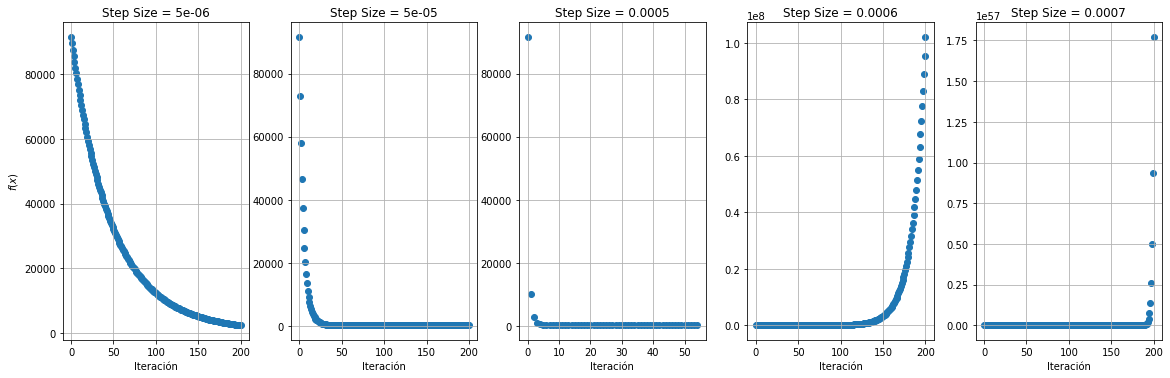

In [6]:
# Se crea una figura con 3 subplots de 16x5 in
fig, axs = plt.subplots(1, len(step_sizes))
fig.set_size_inches(16, 5)
fig.tight_layout()

# Se agregan las gráficas requeridas
for idx, val in enumerate(step_sizes):

    # Se extraen los datos del diccionario como arrays
    iters = runs_GD[val]["k"].to_numpy()
    norm_df = runs_GD[val]["f"].to_numpy()

    # Se grafican los datos y se les coloca un título
    axs[idx].scatter(iters, norm_df)
    axs[idx].set_title(f'Step Size = {val}')

    # Se activan las grids
    axs[idx].grid(True)

# Coloca X labels comunes
for ax in axs.flat:
    ax.set(xlabel='Iteración')

# Setea una Y label solo para el primer plot
axs[0].set(ylabel='$f(x)$')

plt.show()

- Como se puede observar en las gráficas de arriba, el método de gradient descent es efectivo, pero únicamente bajo las condiciones adecuadas. El algoritmo se corrió con diferentes step sizes y este únicamente consiguió converger cuando se utilizaron valores muy específicos. Curiosamente, los step-sizes parecen contar con un "valor límite" a partir del cual ya no se debe incrementar o el método diverge. El método mejora su tasa de convergencia a medida que se incrementa el valor, pero una vez se alcanza un step-size de aproximadamente 0.0006, el método diverge. Por lo tanto, el mejor valor a emplear es el de 0.0005, el valor más grande posible antes de que el algoritmo comience a diverger.

  Tomando en cuenta todo lo anterior, se puede declarar que este método es útil, aunque probablemente sería adecuado primero obtener el step-size de forma exacta y seguido de esto emplearlo para ejecuciones posteriores. De esta manera ya no se debe pasar por una fase de experimentación previa para determinar bajo que situaciones el algoritmo diverge.

### Parte 3 - Stochastic Gradient Descent

En esta parte deberá implementar el algoritmo de SGD para resolver aproximadamente el problema. Ejecute este algoritmo 3 veces, una para cada uno de los siguientes step sizes (o learning rates) constantes: 0.0005, 0.005 y 0.01. Inicialice el vector $x$ con el vector nulo y realice 1000 iteraciones para cada step size. Realice un gráfico de la función objetivo $f$ versus el número de iteraciones para cada uno de los 3 step sizes dados. Las tres gráficas deben estar en el mismo plano. Finalmente, comente cómo el step size afecta la convergencia del SGD, puede experimentar con otros step sizes para justificar su respuesta. ¿Con cuál step size constante obtuvo el "mejor" resultado?

In [7]:
def stochasticGradientDescent(f, df, x0, epsilon = 1E-6, max_iter = 100, learning_rate = 0.001): 

    # Paquetes necesarios
    from numpy.linalg import norm

    # Se coloca x0 como primer valor de xk
    xk = x0.copy()

    # Iteración actual e índice actual
    k = 0                           
    idx = 0

    # Se inicializa el dataframe que almacenará los datos de cada iteración
    table = pd.DataFrame(columns = ["k", "Xk", "Pk", "f"])

    # Se agregan los datos de la primera fila
    table = table.append({"k": 0, "Xk": xk, "Pk": df(xk,idx), "f": f(xk)}, ignore_index=True)

    
    # Se crea un vector con números de 1 hasta "n"
    # Las filas del vector se "shufflean"
    idxs = np.arange(0,n,1)
    idxs = np.random.permutation(idxs)

    # Método de GD:
    # - Determinar la dirección pk
    # - Determinar el step size ak
    # - Iterar sobre la aproximación inicial utilizando x_k+1 = xk + ak*pk
    while (np.abs(df(xk, idx)) >= epsilon).any() and (k < max_iter):

        # Se toman las muestras una a una y se utilizan
        # para actualizar al vector X
        for idx in idxs:

            # Dirección: grad(f)
            grad = df(xk, idx)

            # Iteración:
            xk = xk - learning_rate * grad

            # Se incrementa el número de iteraciones
            k += 1

            # Se agrega la información actual al dataframe
            table = table.append({"k": k, "Xk": xk, "Pk": grad, "f": f(xk)}, ignore_index=True)

            # Si se alcanza la precisión deseada, se interrumpe el "for"
            if not ((np.abs(df(xk,idx)) >= epsilon).any() and (k < max_iter)):
                break

    return table

Se ejecuta el algoritmo para cada uno de los step-sizes requeridos. Se guardan los resultados obtenidos en diferentes tablas.

In [8]:
# Lista de los step sizes a probar
step_sizes = [0.0005, 0.005, 0.01]

# Derivada de la función objetivo
df = lambda x, idx: 2*np.reshape(A[idx,:], (-1,1)) @ (x.T @ np.reshape(A[idx,:], (-1,1)) - b[idx,0])

# Vector inicial nulo (Con las mismas dimensiones de X_true)
x0 = np.zeros_like(X_true)

# Diccionario para guardar las tablas resultantes
runs_SGD = {}

# Se aplica gradient descent utilizando diferentes step sizes
for step_size in step_sizes:

    # Se ejecuta el algoritmo con el step-size deseado
    tabla = stochasticGradientDescent(f, df, x0, learning_rate=step_size, max_iter=1000)

    # Se guarda la tabla en el diccionario de runs
    runs_SGD[step_size] = tabla

Se grafica la progresión en la disminución objetivo del valor de la función objetivo a lo largo de cada una de las "epochs" o iteraciones del algoritmo.

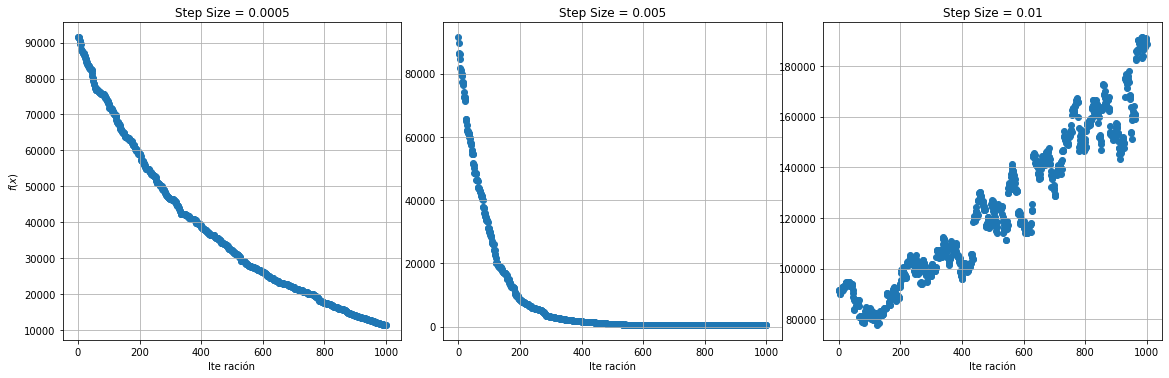

In [9]:
# Se crea una figura con 3 subplots de 16x5 in
fig, axs = plt.subplots(1, len(step_sizes))
fig.set_size_inches(16, 5)
fig.tight_layout()

# Se agregan las gráficas requeridas
for idx, val in enumerate(step_sizes):

    # Se extraen los datos del diccionario como arrays
    iters = runs_SGD[val]["k"].to_numpy()
    norm_df = runs_SGD[val]["f"].to_numpy()

    # Se grafican los datos y se les coloca un título
    axs[idx].scatter(iters, norm_df)
    axs[idx].set_title(f'Step Size = {val}')

    # Se activan las grids
    axs[idx].grid(True)

# Coloca X labels comunes
for ax in axs.flat:
    ax.set(xlabel='Iteración')

# Setea una Y label solo para el primer plot
axs[0].set(ylabel='$f(x)$')

plt.show()

- Los resultados fueron similares a los observados en el caso del descenso gradiente simple: Mientras más grande es el step size, más rápida la convergencia. Sin embargo, existe un punto a partir del cual el algoritmo diverge si se incrementa demasiado el step size. El "umbral de divergencia" en este caso parece consistir de un step size = 0.01. La única diferencia con respecto al descenso de gradiente tradicional es que el algoritmo converge más lento y de forma mucho más ruidosa debido a la introducción del elemento estocástico propio del algoritmo.

### Parte 4 - Minibatch Gradient Descent

Repita la parte 3, pero ahora implemente el algoritmo de MBGD para resolver aproximadamente el problema. Para ello, utilice batches de tamaño 25, 50 y 100, considerando para cada uno de estos casos los siguientes step sizes (o learning rates) constantes: 0.0005, 0.005 y 0.01. ¿Cómo el tamaño del batch afecta la convergencia de este algoritmo? ¿Con cuál combinación de batch size y step size obtuvo el mejor resultado? Justifique su respuesta.

In [10]:
def minibatchGradientDescent(f, df, x0, batch_size=25, epsilon = 1E-6, max_iter = 100, learning_rate = 0.001, params={"A": 0, "b": 0}): 

    # Paquetes necesarios
    from numpy.linalg import norm

    # Se coloca x0 como primer valor de xk
    xk = x0.copy()

    # Iteración actual e índice actual
    k = 0                           

    # =============
    # PREPARACIÓN BATCHES
    # =============

    # Se crea un vector con números de 1 hasta "n"
    # Las filas del vector se "shufflean"
    idxs = np.arange(0,n,1)
    idxs = np.random.permutation(idxs)
    idx = 0

    # Los índices "shuffleados" se usan para "mezclar" las filas de "A" y "b" 
    A = params["A"].take(idxs, 0)
    b = params["b"].take(idxs, 0)

    # Se extrae el número de batches (en forma de int)
    num_batches = xk.shape[0] // batch_size

    # =============
    # TABLA
    # =============

    # Se inicializa el dataframe que almacenará los datos de cada iteración
    table = pd.DataFrame(columns = ["k", "Xk", "||df||", "f"])

    # Se agregan los datos de la primera fila
    table = table.append({"k": 0, "Xk": xk, "||df||": norm(df(xk, A, b)), "f": f(xk)}, ignore_index=True)

    # Método de GD:
    # - Determinar la dirección pk
    # - Determinar el step size ak
    # - Iterar sobre la aproximación inicial utilizando x_k+1 = xk + ak*pk
    while (norm(df(xk, A, b)) >= epsilon) and (k < max_iter):

        # Para cada batch
        for batch in range(num_batches):

            # Inicio de batch: Número de batch por el batch size
            strt = batch*batch_size

            # Fin de batch: Inicio + batch size - 1
            if batch == num_batches-1:
                end = xk.shape[0]
            else:
                end = strt + batch_size - 1

            # Se selecciona el "batch" de datos a utilizar de A y b
            A_sel = A[strt:end, :]
            b_sel = b[strt:end, :]

            # Dirección: grad(f)
            grad = df(xk, A_sel, b_sel)

            # Iteración:
            xk = xk - learning_rate * grad

            # Se incrementa el número de iteraciones
            k += 1

            # Se agrega la información actual al dataframe
            table = table.append({"k": k, "Xk": xk, "||df||": norm(grad), "f": f(xk)}, ignore_index=True)

            # Si se alcanza la precisión deseada, se interrumpe el "for"
            if not ((np.abs(df(xk, A, b)) >= epsilon).any() and (k < max_iter)):
                break

    return table

Se realiza una corrida por cada combinación de step size y batch size a probar.

In [11]:
# Lista de los step sizes a probar
step_sizes = [0.0005, 0.005, 0.01]

# Lista de los batch sizes a probar
batch_sizes = [25, 50, 100]

# Derivada de la función objetivo
df = lambda x, A, b : 2 * A.T @ (A @ x - b)

# Vector inicial nulo (Con las mismas dimensiones de X_true)
x0 = np.zeros_like(X_true)

# Diccionario para guardar las tablas resultantes
runs_MBGD = {}

# Se aplica gradient descent utilizando diferentes step sizes
for step_size in step_sizes:

    for batch_size in batch_sizes:

        # Se ejecuta el algoritmo con el step-size deseado
        tabla = minibatchGradientDescent(f, df, x0, batch_size=batch_size, learning_rate=step_size, max_iter=1000, params={"A": A, "b": b})

        # Se guarda la tabla en el diccionario de runs
        runs_MBGD[f"{step_size}, {batch_size}"] = tabla

C:\Users\eddys\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-2-d0b8de9cab90>:20: RuntimeWarning: overflow encountered in square
  f = lambda x : np.sum((A @ x - b)**2, axis=0, keepdims=True).item()
<ipython-input-11-d870e720f986>:8: RuntimeWarning: overflow encountered in matmul
  df = lambda x, A, b : 2 * A.T @ (A @ x - b)
<ipython-input-11-d870e720f986>:8: RuntimeWarning: invalid value encountered in matmul
  df = lambda x, A, b : 2 * A.T @ (A @ x - b)
<ipython-input-10-b4375c5dd772>:65: RuntimeWarning: invalid value encountered in subtract
  xk = xk - learning_rate * grad
<ipython-input-2-d0b8de9cab90>:20: RuntimeWarning: invalid value encountered in matmul
  f = lambda x : np.sum((A @ x - b)**2, axis=0, keepdims=True).item()


Se grafican todas las combinaciones de batch size y step size obtenidas en las corridas anteriores. Dado que en algunos casos el algoritmo diverge, los datos de costo se limpian antes de ser graficados para evitar errores por valores infinitos y NaNs.

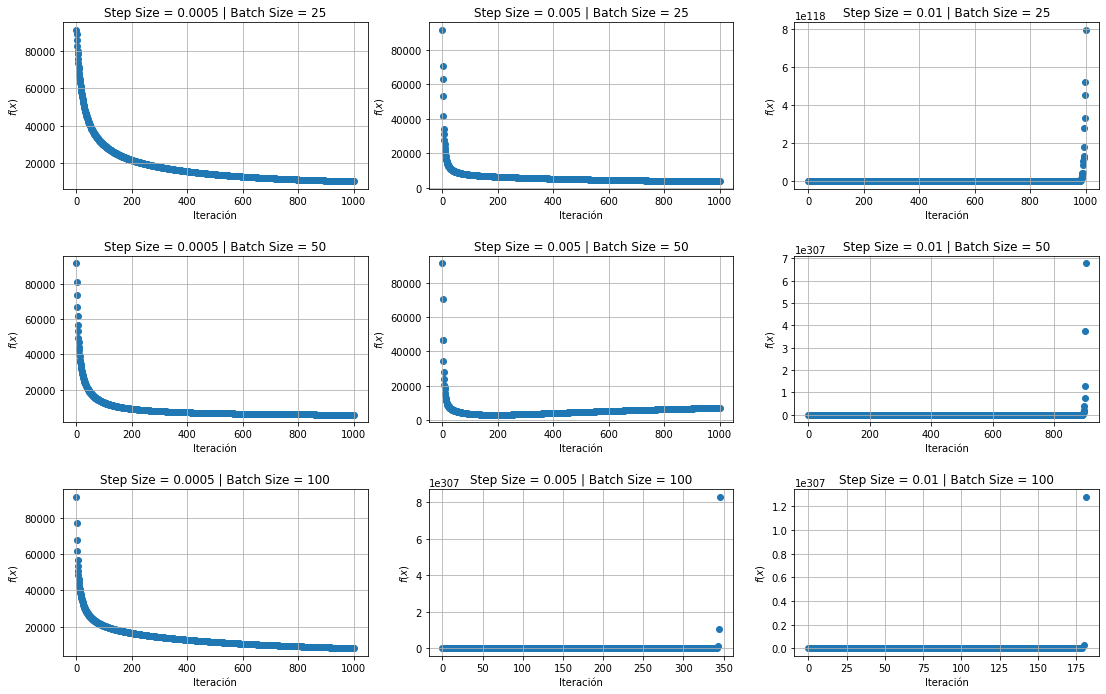

In [13]:
from numpy import logical_not
from numpy.ma import masked_invalid

# Se crea una figura con 3 subplots de 16x5 in
fig, axs = plt.subplots(len(batch_sizes), len(step_sizes))
fig.set_size_inches(16, 11)

# Se agregan las gráficas requeridas
for idx_sz, step_size in enumerate(step_sizes):

    for idx_bs, batch_size in enumerate(batch_sizes):

        # Se extraen los datos del diccionario como arrays
        iters = runs_MBGD[f"{step_size}, {batch_size}"]["k"].to_numpy()
        cost  = runs_MBGD[f"{step_size}, {batch_size}"]["f"].to_numpy()

        # Se limpia "cost" de Infs y NaNs. "iters" se ajusta de forma acorde
        iters = iters[logical_not(masked_invalid(cost).mask)]
        cost  =  cost[logical_not(masked_invalid(cost).mask)]

        # Se grafican los datos y se les coloca un título
        axs[idx_bs, idx_sz].scatter(iters, cost)
        axs[idx_bs, idx_sz].set_title(f'Step Size = {step_size} | Batch Size = {batch_size}')

        # Se activan las grids
        axs[idx_bs, idx_sz].grid(True)

# Coloca X labels comunes
for ax in axs.flat:
    ax.set(xlabel='Iteración', ylabel="$f(x)$")

# Se ajusta la distancia entre plots
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

- Al igual que en los dos casos anteriores, el MBGD cuenta con un threshold superior a partir del cual el algoritmo comienza a diverger. En este caso particular sin embargo, tanto la elección de step size, como de batch size influyen en la tasa de convergencia del mismo. Si tanto el batch size, como el step size se encuentran en un valor ideal, el algoritmo converge de forma súmamente rápida (por ejemplo, con la combinación de un step size = 0.005 y un batch size = 50). Sin embargo, si se incrementan demasiado los dos parámetros, el algoritmo comienza a diverger cada vez más rápido. A partir de las pruebas anteriores, se pudo llegar a determinar que un step size = 0.01 es demasiado agresivo, por lo que no importando el tamaño de batch, el algoritmo siempre diverge. Por lo tanto, esta variación de descenso de gradiente posee un desempeño comparable (si no mejor) que el del algoritmo tradicional, no obstante, se le agrega un parámetro adicional sobre el que se debe de tener control.

### Parte 5 - Comparación

Compare el desempeño de cada uno de los métodos implementados. Realice una lista de posiciones ordenando los métodos de mejor a peor desempeño. Para ello, considere el valor óptimo de la función objetivo $f^*$ alcanzado, el número de iteraciones requeridas y por supuesto, el error en el $x^*$ obtenido versus el $x$ real ($x_{true}$).

In [41]:
# Se crean los diccionarios donde se alamacenarán datos
costs = {}
iters = {}
X_exp = {}
MSE = {}

# Se obtienen los costos más bajos obtenidos por cada método en su mejor configuración
costs["GD"] = runs_GD[0.0005].iloc[-1,:]["f"]
costs["SGD"] = runs_SGD[0.005].iloc[-1,:]["f"]
costs["MBGD"] = runs_MBGD["0.005, 25"].iloc[-1,:]["f"]

# Se obtiene el número de iteración para cada método en su mejor configuración
iters["GD"] = runs_GD[0.0005].iloc[-1,:]["k"]
iters["SGD"] = runs_SGD[0.005].iloc[-1,:]["k"]
iters["MBGD"] = runs_MBGD["0.005, 25"].iloc[-1,:]["k"]

# Se obtiene la última aproximación de X* para cada método
X_exp["GD"] = runs_GD[0.0005].iloc[-1,:]["Xk"]
X_exp["SGD"] = runs_SGD[0.005].iloc[-1,:]["Xk"]
X_exp["MBGD"] = runs_MBGD["0.005, 25"].iloc[-1,:]["Xk"]

# Se obtiene el MSE entre el X* obtenido y el X_true
MSE["GD"] = np.mean((X_exp["GD"] - X_true)**2)
MSE["SGD"] = np.mean((X_exp["SGD"] - X_true)**2)
MSE["MBGD"] = np.mean((X_exp["GD"] - X_true)**2)

# Se presentan los resultados en una tabla
df_comparacion = pd.DataFrame([iters, costs, MSE], ["Iters", "Cost", "MSE"])
df_comparacion

,GD,SGD,MBGD
Iters,54.000000,1000.000000,1000.000000
Cost,216.393813,443.417785,3781.285444
MSE,0.000273,0.002576,0.000273


Al comparar cada uno de los métodos empleados, se puede observar que, al menos de forma experimental, cada uno cuenta con sus ventajas y sus desventajas. El método de descenso de gradiente tradicional parece ser el mejor método, al obtener tanto el costo como el MSE más bajos y todo utilizando un número de iteraciones mucho menor. La desventaja del mismo, es que este carece de escalabilidad. Todas las ventajas anteriormente mencionadas provienen del hecho que el descenso de gradiente procesa todas las muestras de entrenamiento a la vez. Esto es sencillo para un "dataset" pequeño como el utilizado, pero en casos donde los datos alcanzan los millones o billones (como comúnmente ocurre aplicaciones de data science), esto rápidamente se torna muy computacionalmente costoso. 

Seguido de esto tenemos al descenso de gradiente estocástico. Este requiere de muchas más iteraciones (casi 950 más) a comparación del descenso de gradiente tradicional, pero este consigue alcanzar un valor de costo similar, utilizando una fracción de la carga computacional que utiliza el GD. La desventaja de este método es que toma más tiempo en computarse (cada muestra se procesa individualmente) y cuenta con una convergencia más "ruidosa" (debido a la elección aleatoria de muestras).

Finalmente se encuentra el mini batch gradient descent (MBGD). Este es un método interesante en términos de sus resultados. Dado que el mismo combina elementos de tanto GD como SGD, el mismo converge a una velocidad similar a la del SGD, pero alcanza una precisión similar a la del GD (denotado por sus MSE idénticos). Este emplea un poco más de capacidad computacional a comparación del SGD, pero nunca tanto como el GD y debido a que toma pequeños "batches" del dataset completo a la vez, su trayectoria de convergencia es mucho más suave. La única desventaja de este método es que su costo o valor de la función objetivo es peor al de ambos métodos, aunque esto probablemente se deba a un error en programación.

Tomando todo lo anterior en cuenta, y que estos algoritmos se utilizarán específicamente para "data science", se establece el siguiente "ranking" experimental (de mejor a peor):

1. Mini-batch gradient descent (MBGD)
2. Batch gradient descent (BGD)
3. Stochastic gradient descent (SGD)

El MBGD probó consistir del mejor método entre ambos, ya que ofrece el mejor tradeoff entre requisitos computacionales y precisión. Le sigue el BGD, ya que ningún otro algoritmo pudo llegar alcanzar la misma precisión con la misma rapidez. No se colocó en primero, debido a la seria limitante de términos de capacidad computacional requerida. Finalmente, se encuentra el SGD. Este no es malo y de hecho podría colocarse como un segundo "segundo lugar", pero este no solo converge más lento, si no que también lo hace de forma ruidosa, por lo que se arriesga a que se dificulte la convergencia sin razón aparente.

------------------------

## Problema 2 - Método de Newton

Considere de nuevo el problema de optimización

$$
\min _{\left(x_{1}, x_{2}\right) \in \mathbb{R}^{2}} f\left(x_{1}, x_{2}\right)=100\left(x_{2}-x_{1}^{2}\right)^{2}+\left(1-x_{1}\right)^{2}
$$

Recuerde que la función objetivo de este problema es conocida como *Rosenbrock's Function* y es utilizada como benchmark en la evaluación de algoritmo. 

### Parte 1 - GD con Backtracking Line Search

En el laboratorio anterior, se aplicó el método de GD (con un step size constante) para resolver el problema. Ahora, utilice *Backtracking Line Search* para determinar el step size. Fije los parámetros de este algoritmo de acuerdo a los valores dados en clase. Compare los resultados de ambas formas de determinar el step size, para ello utilice $x_{0}=(0,0)^{T}$, $(0.6,0.6)^{T}$, $(-0.5,1)^{T}$ y $(-1.2,1)^{T}$.

In [79]:
# Gradient descent con Backtracking Line Search (BLS)
def gradientDescentBLS(f, df, x0, epsilon = 1e-6, max_iter = 100): 

    # Paquetes necesarios
    from numpy.linalg import norm
    import time

    # Se coloca x0 como primer valor de xk
    xk = x0.copy()

    # Iteración actual
    k = 0                           

    # Se inicializa el dataframe que almacenará los datos de cada iteración
    table = pd.DataFrame(columns = ["k", "Xk", "Pk", "||df||", "f"])

    # Se agregan los datos de la primera fila
    table = table.append({"k": 0, "Xk": xk, "Pk": df(xk), "||df||": norm(df(xk)), "f": f(xk)}, ignore_index=True)

    # Método de GD:
    # - Determinar la dirección pk
    # - Determinar el step size ak
    # - Iterar sobre la aproximación inicial utilizando x_k+1 = xk + ak*pk
    while (norm(df(xk)) >= epsilon) and (k < max_iter):

        # Se incrementa el número de iteraciones
        k += 1

        # Dirección: grad(f)
        grad = df(xk)

        # =====================
        # Backtracking Line Search
        
        # Se inicializan los parámetros
        alpha_bar = 1
        rho = 0.5
        c = 1e-4

        # Se asigna alpha_bar a alpha
        alpha = alpha_bar
        pk = grad.copy()
        
        # Se itera hasta que la condición esa falsa
        # (Se debe cumplir la condición de Armijo)
        while f(xk + alpha*pk) > (f(xk) + c*alpha * df(xk).T @ pk):
            alpha = rho * alpha
        
        # =====================

        # Iteración:
        xk = xk - alpha * grad

        # Se agrega la información actual al dataframe
        table = table.append({"k": k, "Xk": xk, "Pk": grad, "||df||": norm(grad), "f": f(xk)}, ignore_index=True)

    return table

Se ejecutan las pruebas para cada uno de los puntos iniciales.

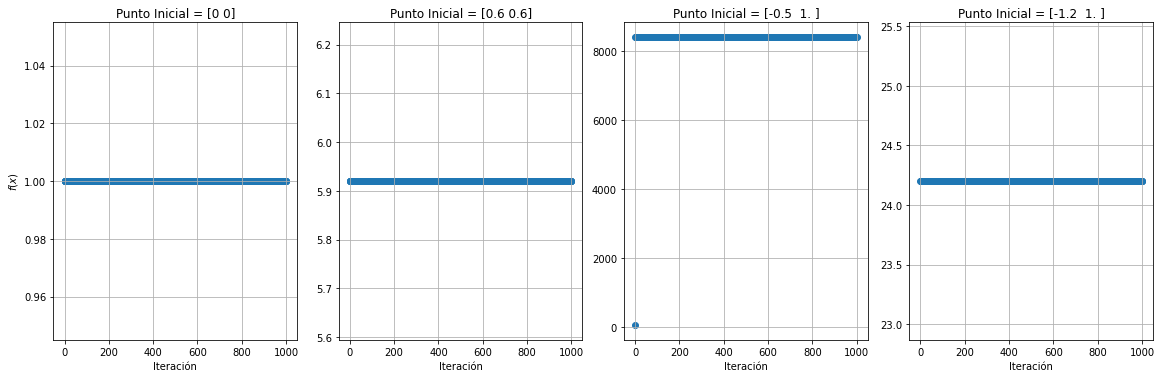

In [82]:
# ==================
# RUNS
# ==================

# Función de Rosenbrock
f = lambda x : 100*(x[1,0] - x[0,0]**2)**2 + (1-x[0,0])**2

# Gradiente de función de Rosenbrock
df = lambda x: np.array([[-400*(-x[0,0]**3 + x[0,0]*x[1,0]) - 2*(1-x[0,0])],
                         [ 200*(-x[0,0]**2 + x[1,0])                     ]])

# Cada uno de los puntos iniciales
x0s = [np.array([[   0,   0]]).T,
       np.array([[ 0.6, 0.6]]).T,
       np.array([[-0.5,   1]]).T,
       np.array([[-1.2,   1]]).T]

# Diccionario para guardar las tablas resultantes
runs_GDBLS = {}

# Para cada punto inicial
for x0 in x0s:

    # Entrenamiento
    tabla = gradientDescentBLS(f, df, x0, epsilon=1e-4, max_iter=1000)

    # Se crea un string que representa el array   
    arrayStr = np.array2string(x0.flatten())

    # Se guarda la tabla en el diccionario de runs
    runs_GDBLS[arrayStr] = tabla

# ==================
# PLOTS
# ==================

# Se crea una figura con 3 subplots de 16x5 in
fig, axs = plt.subplots(1, len(x0s))
fig.set_size_inches(16, 5)
fig.tight_layout()

# Se agregan las gráficas requeridas
for idx, x0 in enumerate(x0s):

    # Se crea un string que representa el array   
    arrayStr = np.array2string(x0.flatten())

    # Se extraen los datos del diccionario como arrays
    iters = runs_GDBLS[arrayStr]["k"].to_numpy()
    norm_df = runs_GDBLS[arrayStr]["f"].to_numpy()

    # Se grafican los datos y se les coloca un título
    axs[idx].scatter(iters, norm_df)
    axs[idx].set_title(f'Punto Inicial = {arrayStr}')

    # Se activan las grids
    axs[idx].grid(True)

# Coloca X labels comunes
for ax in axs.flat:
    ax.set(xlabel='Iteración')

# Setea una Y label solo para el primer plot
axs[0].set(ylabel='$f(x)$')

plt.show()

Las gráficas generadas parecen indicar que el algoritmo de BLS no está funcionando correctamente. No obstante, al investigar un poco más sobre las operaciones internas del algoritmo, se pudo llegar a observar que el mismo si está en funcionamiento. Sin embargo, debido a que este se basa en reducir el step size hasta eventualmente cumplir con las condiciones de Armijo y las mismas no se cumplen durante un gran número de iteraciones, el valor del step size termina tomando un valor en el orden de 1x10^-17. Esto implica que cada cambio al vector inicial $x_k$ es virtualmente nulo y por lo tanto, el mismo permanece constante a lo largo de casi todas las iteraciones. Esto es un indicador que, para métodos que no incluyen el valor de la segunda derivada en la formulación de su modelo, no es apta la inclusión del BLS. La utilización de un valor constante o de algún otro método basado en momentos por ejemplo, resulta en la mejor opción.

### Parte 2 - Método de Newton con Backtracking Line Search

Aplique el método de Newton para resolver este problema de optimización. Al igual que en el problema, utilice $x_{0}=(0,0)^{T}$ y un step-size unitario. ¿Qué sucede si varía el punto inicial a $(0.6,0.6)^{T}$, $(-0.5,1)^{T}$ y $(-1.2,1)^{T}$ y si el step size lo calcula utilizando *Backtracking Line Search*? Experimente con estos parámetros y reporte sus hallazgos. Detenga la ejecución del algoritmo cuando $\left\|\nabla f\left(x_{k}\right)\right\|<10^{-8}$ o bien cuando el número de iteraciones exceda 3000. Su output debe ser mostrado en una tabla con las cuatro columnas siguientes:

1. El número $k$ de la iteración
2. $x_k$
3. La dirección $p_k$
4. $||\nabla f(x_k)||$

In [105]:
# Gradient descent con Backtracking Line Search (BLS)
def NewtonBLS(f, df, ddf, x0, epsilon = 1e-6, max_iter = 100, alpha_override = None): 

    # Paquetes necesarios
    from numpy.linalg import norm, inv
    import time

    # Se coloca x0 como primer valor de xk
    xk = x0.copy()

    # Iteración actual
    k = 0                           

    # Se inicializa el dataframe que almacenará los datos de cada iteración
    table = pd.DataFrame(columns = ["k", "Xk", "Pk", "||df||", "f"])

    # Se agregan los datos de la primera fila
    table = table.append({"k": 0, "Xk": xk, "Pk": df(xk), "||df||": norm(df(xk)), "f": f(xk)}, ignore_index=True)

    # Método de GD:
    # - Determinar la dirección pk
    # - Determinar el step size ak
    # - Iterar sobre la aproximación inicial utilizando x_k+1 = xk + ak*pk
    while (norm(df(xk)) >= epsilon) and (k < max_iter):

        # Se incrementa el número de iteraciones
        k += 1

        # Dirección: -[ddf(x)]^-1 df(x)
        pk = -inv(ddf(xk)) @ df(xk)

        # =====================
        # Backtracking Line Search
        
        # Se inicializan los parámetros
        alpha_bar = 1
        rho = 0.5
        c = 1e-4

        # Se asigna alpha_bar a alpha
        alpha = alpha_bar
        
        # Se itera hasta que la condición esa falsa
        # (Se debe cumplir la condición de Armijo)
        while f(xk + alpha*pk) > (f(xk) - c*alpha * df(xk).T @ pk):
            alpha = rho * alpha
        
        # =====================

        if alpha_override:
            alpha = alpha_override

        # Iteración:
        xk = xk + alpha * pk

        # Se agrega la información actual al dataframe
        table = table.append({"k": k, "Xk": xk, "Pk": pk, "||df||": norm(df(xk)), "f": f(xk)}, ignore_index=True)

    return table

Se ejecutan los runs para cada uno de los puntos iniciales, incluyendo la prueba en la que el step size permanece siempre en un valor constante de 1

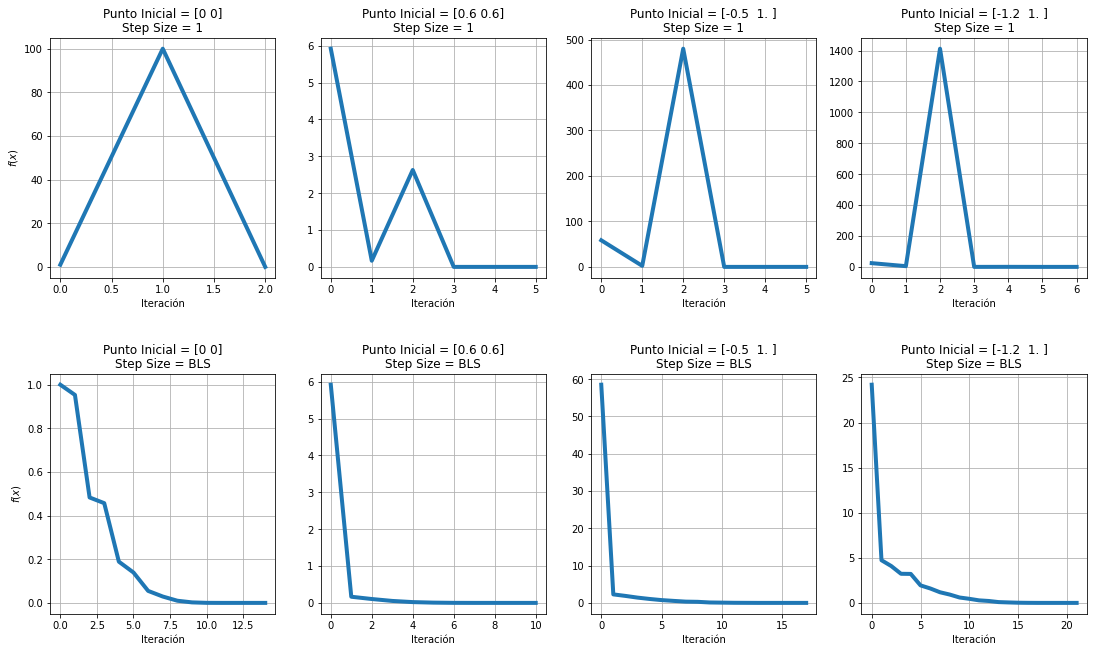

In [117]:
# ==================
# RUNS
# ==================

# Función de Rosenbrock
f = lambda x : 100*(x[1,0] - x[0,0]**2)**2 + (1-x[0,0])**2

# Gradiente de función de Rosenbrock
df = lambda x: np.array([[-400*(-x[0,0]**3 + x[0,0]*x[1,0]) - 2*(1-x[0,0])],
                         [ 200*(-x[0,0]**2 + x[1,0])                     ]])

# Hessiano de la función de Rosenbrock
ddf = lambda x: np.array([[-400*(-3*x[0,0]**2 + x[1,0]) + 2, -400*x[0,0]],
                          [                     -400*x[0,0],         200]])

# Cada uno de los puntos iniciales
x0s = [np.array([[   0,   0]]).T,
       np.array([[ 0.6, 0.6]]).T,
       np.array([[-0.5,   1]]).T,
       np.array([[-1.2,   1]]).T,
       # Con backtraing line search
       np.array([[   0,   0]]).T,
       np.array([[ 0.6, 0.6]]).T,
       np.array([[-0.5,   1]]).T,
       np.array([[-1.2,   1]]).T]

# Diccionario para guardar las tablas resultantes
runs_NBLS = {}

# Para cada punto inicial
for idx, x0 in enumerate(x0s):

    # Se crea un string que representa el array   
    arrayStr = np.array2string(x0.flatten())

    # Entrenamiento
    if idx < 4:
        tabla = NewtonBLS(f, df, ddf, x0, epsilon=1e-8, max_iter=3000, alpha_override=1)
        runs_NBLS[arrayStr+"1"] = tabla
    else: 
        tabla = NewtonBLS(f, df, ddf, x0, epsilon=1e-8, max_iter=3000)
        runs_NBLS[arrayStr] = tabla
        

# ==================
# PLOTS
# ==================

# Se crea una figura con 3 subplots de 16x5 in
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(16, 10)
fig.tight_layout()

# Fila de la gráfica
# Se inicializa en -1 para que cuando le agregue 1 en la lógica anterior
# la primera fila tenga índice de 0
row = -1

# Se agregan las gráficas requeridas
for idx, x0 in enumerate(x0s):

    # Si se llega a un múltiplo de 4, se agrega 1 al número de fila
    if idx % 4 == 0:
        row += 1

    # El número de columna es el módulo de 4 del index
    col = idx % 4

    # Se crea un string que representa el array   
    arrayStr = np.array2string(x0.flatten())

    # Si se trata de los primeros 4 plots (con step size = 1)
    if idx < 4:
        axs[row,col].set_title(f'Punto Inicial = {arrayStr}\nStep Size = 1')
        iters   = runs_NBLS[arrayStr+"1"]["k"].to_numpy()
        norm_df = runs_NBLS[arrayStr+"1"]["f"].to_numpy()

    # Si se trata de los últimos 4 plots (con step size = BLS)
    else:
        axs[row,col].set_title(f'Punto Inicial = {arrayStr}\nStep Size = BLS')
        iters   = runs_NBLS[arrayStr]["k"].to_numpy()
        norm_df = runs_NBLS[arrayStr]["f"].to_numpy()

    # Se grafican los datos y se les coloca un título
    axs[row,col].plot(iters, norm_df, linewidth=4)

    # Se activan las grids
    axs[row,col].grid(True)

# Coloca X labels comunes
for ax in axs.flat:
    ax.set(xlabel='Iteración')

# Setea una Y label solo para el primer plot
axs[0,0].set(ylabel='$f(x)$')
axs[1,0].set(ylabel='$f(x)$')

# Se ajusta la distancia entre plots
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

Al emplear un step size unitario, todos los algoritmos convergieron en una cantidad increíblemente pequeña de iteraciones (6 o menos), esto a pesar de que se le haya dado al algoritmo un máximo de 3000 iteraciones y que su punto inicial se haya variado. Esto demuestra la gran capacidad de los modelos que incluyen la curvatura de la función objetivo dentro de su formulación (como es el caso del método de Newton). A pesar de esta ventaja significativa, es importante mencionar que el valor de la función objetivo fluctúa agresivamente mientras es minimizada, aunque el método de Newton es capaz de auto-corregirse para regresar al punto en el que se encontraba.

Al emplear un step size encontrado a través de backtracking line search, el algoritmo tendió a tomar un poco más de tiempo en converger (entre 10 a 20 iteraciones), pero presentó una trayectoria un poco más "limpia" en términos de la minimización de su función objetivo. Otra característica particular de las curvas de minimización al utilizar BLS, es que en la mayoría de las posiciones iniciales, el algoritmo fue capaz de llegar a un valor "suficientemente bueno" de su función objetivo de forma casi inmediata y seguido de esto, únicamente se reguló para continuar minimizando hacia el mínimo buscado. Por lo tanto, al acoplarle BLS al método de Newton, este se torna ligeramente más lento en términos de su convergencia, pero el step size deja de consistir de un hiperparámetro a calibrar por parte del usuario.

Para determinar cual de los dos métodos es superior, se deben de tomar en cuenta las preferencias del experimentador: Se valora más un tiempo de convergencia bajo, pero que requiere de mayor experimentación (Step Size Constante) o la conveniencia de no necesitar que experimentar con un parámetro adicional y que devuelve resultados casi iguales a los anteriores (BLS).